# **Window Function**

We will use dc_bikeshare_q1_2012 table again that we used in day-3 lecture. However, if you already removed the table, you can run these query that stored in a sql script. You can access the script [here](https://github.com/FTDS-learning-materials/phase-0/blob/main/src/w2d3pm.sql).

A window function performs a calculation across a set of table rows that are somehow related to the current row. This is comparable to the type of calculation that can be done with an aggregate function. But unlike regular aggregate functions, use of a window function does not cause rows to become grouped into a single output row — the rows retain their separate identities. Behind the scenes, the window function is able to access more than just the current row of the query result.

The most practical example of this is a running total:

```sql
SELECT duration_seconds,
       SUM(duration_seconds) OVER (ORDER BY start_time) AS running_total
  FROM dc_bikeshare_q1_2012
```

When using window functions, you can apply the same aggregates that you would under normal circumstances—SUM, COUNT, and AVG. The easiest way to understand these is to re-run the previous example with some additional functions. Make

```sql
SELECT start_terminal,
       duration_seconds,
       SUM(duration_seconds) OVER
         (PARTITION BY start_terminal) AS running_total,
       COUNT(duration_seconds) OVER
         (PARTITION BY start_terminal) AS running_count,
       AVG(duration_seconds) OVER
         (PARTITION BY start_terminal) AS running_avg
  FROM dc_bikeshare_q1_2012
 WHERE start_time < '2012-01-08'
```

## ROW_NUMBER()

ROW_NUMBER() does just what it sounds like—displays the number of a given row. It starts are 1 and numbers the rows according to the ORDER BY part of the window statement. ROW_NUMBER() does not require you to specify a variable within the parentheses:

```sql
SELECT start_terminal,
       start_time,
       duration_seconds,
       ROW_NUMBER() OVER (ORDER BY start_time)
                    AS rn
  FROM dc_bikeshare_q1_2012
 WHERE start_time < '2012-01-08'
```

Using the PARTITION BY clause will allow you to begin counting 1 again in each partition. The following query starts the count over again for each terminal:

```sql
SELECT start_terminal,
       start_time,
       duration_seconds,
       ROW_NUMBER() OVER (PARTITION BY start_terminal
                          ORDER BY start_time)
                    AS rn
  FROM dc_bikeshare_q1_2012
 WHERE start_time < '2012-01-08'
```

## RANK() and DENSE_RANK()

RANK() is slightly different from ROW_NUMBER(). If you order by start_time, for example, it might be the case that some terminals have rides with two identical start times. In this case, they are given the same rank, whereas ROW_NUMBER() gives them different numbers. In the following query, you notice the 4th and 5th observations for start_terminal 31000—they are both given a rank of 4, and the following result receives a rank of 6:

```sql
SELECT start_terminal,
       duration_seconds,
       RANK() OVER (PARTITION BY start_terminal
                    ORDER BY start_time)
              AS ranking
  FROM dc_bikeshare_q1_2012
 WHERE start_time < '2012-01-08'
```

You can also use DENSE_RANK() instead of RANK() depending on your application. Imagine a situation in which three entries have the same value. Using either command, they will all get the same rank. For the sake of this example, let's say it's "2." Here's how the two commands would evaluate the next results differently:

- RANK() would give the identical rows a rank of 2, then skip ranks 3 and 4, so the next result would be 5
- DENSE_RANK() would still give all the identical rows a rank of 2, but the following row would be 3—no ranks would be skipped.

You can use window functions to identify what percentile (or quartile, or any other subdivision) a given row falls into. The syntax is NTILE(*# of buckets*). In this case, ORDER BY determines which column to use to determine the quartiles (or whatever number of 'tiles you specify). For example:

```sql
SELECT start_terminal,
       duration_seconds,
       NTILE(4) OVER
         (PARTITION BY start_terminal ORDER BY duration_seconds)
          AS quartile,
       NTILE(5) OVER
         (PARTITION BY start_terminal ORDER BY duration_seconds)
         AS quintile,
       NTILE(100) OVER
         (PARTITION BY start_terminal ORDER BY duration_seconds)
         AS percentile
  FROM dc_bikeshare_q1_2012
 WHERE start_time < '2012-01-08'
 ORDER BY start_terminal, duration_seconds
```

## LAG and LEAD

It can often be useful to compare rows to preceding or following rows, especially if you've got the data in an order that makes sense. You can use LAG or LEAD to create columns that pull values from other rows—all you need to do is enter which column to pull from and how many rows away you'd like to do the pull. LAG pulls from previous rows and LEAD pulls from following rows:

```sql
SELECT start_terminal,
       duration_seconds,
       LAG(duration_seconds, 1) OVER
         (PARTITION BY start_terminal ORDER BY duration_seconds) AS lag,
       LEAD(duration_seconds, 1) OVER
         (PARTITION BY start_terminal ORDER BY duration_seconds) AS lead
  FROM dc_bikeshare_q1_2012
 WHERE start_time < '2012-01-08'
 ORDER BY start_terminal, duration_seconds
```

This is especially useful if you want to calculate differences between rows:

```sql
SELECT start_terminal,
       duration_seconds,
       duration_seconds -LAG(duration_seconds, 1) OVER
         (PARTITION BY start_terminal ORDER BY duration_seconds)
         AS difference
  FROM dc_bikeshare_q1_2012
 WHERE start_time < '2012-01-08'
 ORDER BY start_terminal, duration_seconds
```

The first row of the difference column is null because there is no previous row from which to pull. Similarly, using LEAD will create nulls at the end of the dataset. If you'd like to make the results a bit cleaner, you can wrap it in an outer query to remove nulls:

```sql
SELECT *
  FROM (
    SELECT start_terminal,
           duration_seconds,
           duration_seconds -LAG(duration_seconds, 1) OVER
             (PARTITION BY start_terminal ORDER BY duration_seconds)
             AS difference
      FROM dc_bikeshare_q1_2012
     WHERE start_time < '2012-01-08'
     ORDER BY start_terminal, duration_seconds
       ) sub
 WHERE sub.difference IS NOT NULL
 ```

## NTILE

If you're planning to write several window functions in to the same query, using the same window, you can create an alias. Take the NTILE example above:

```sql
SELECT start_terminal,
       duration_seconds,
       NTILE(4) OVER
         (PARTITION BY start_terminal ORDER BY duration_seconds)
         AS quartile,
       NTILE(5) OVER
         (PARTITION BY start_terminal ORDER BY duration_seconds)
         AS quintile,
       NTILE(100) OVER
         (PARTITION BY start_terminal ORDER BY duration_seconds)
         AS percentile
  FROM dc_bikeshare_q1_2012
 WHERE start_time < '2012-01-08'
 ORDER BY start_terminal, duration_seconds
 ```

# Pivot Data in SQL

## SETUP

Download dataset used in this lecture from here: https://github.com/ardhiraka/PFDS_sources/blob/master/players.csv and https://github.com/ardhiraka/PFDS_sources/blob/master/teams.csv.


You will make two tables using create and insert the data by csv files.

1. First, you may need to run this query to make the tables:

```sql
BEGIN;

CREATE TABLE players (
    full_school_name VARCHAR(255),
    school_name VARCHAR(255),
    player_name VARCHAR(255),
    position VARCHAR(255),
    height FLOAT,
    weight FLOAT,
    year VARCHAR(255),
    hometown VARCHAR(255),
    state VARCHAR(255),
    id INT PRIMARY KEY
);

CREATE TABLE teams (
    division VARCHAR(100),
    conference VARCHAR(100),
    school_name VARCHAR(100),
    roster_url VARCHAR(200),
    id INT PRIMARY KEY
);

COMMIT;
```

2. Then, you can right click on the table name in the database schema and choose `Import/Export Data...`. You may need turn on the Header toggle in the `Options`.

## Pivot Table

Let's start by aggregating the data to show the number of players of each year in each conference, similar to the first example in the inner join lesson:

```sql
SELECT teams.conference AS conference,
       players.year,
       COUNT(1) AS players
  FROM players
  JOIN teams teams
    ON teams.school_name = players.school_name
 GROUP BY 1,2
 ORDER BY 1,2
```

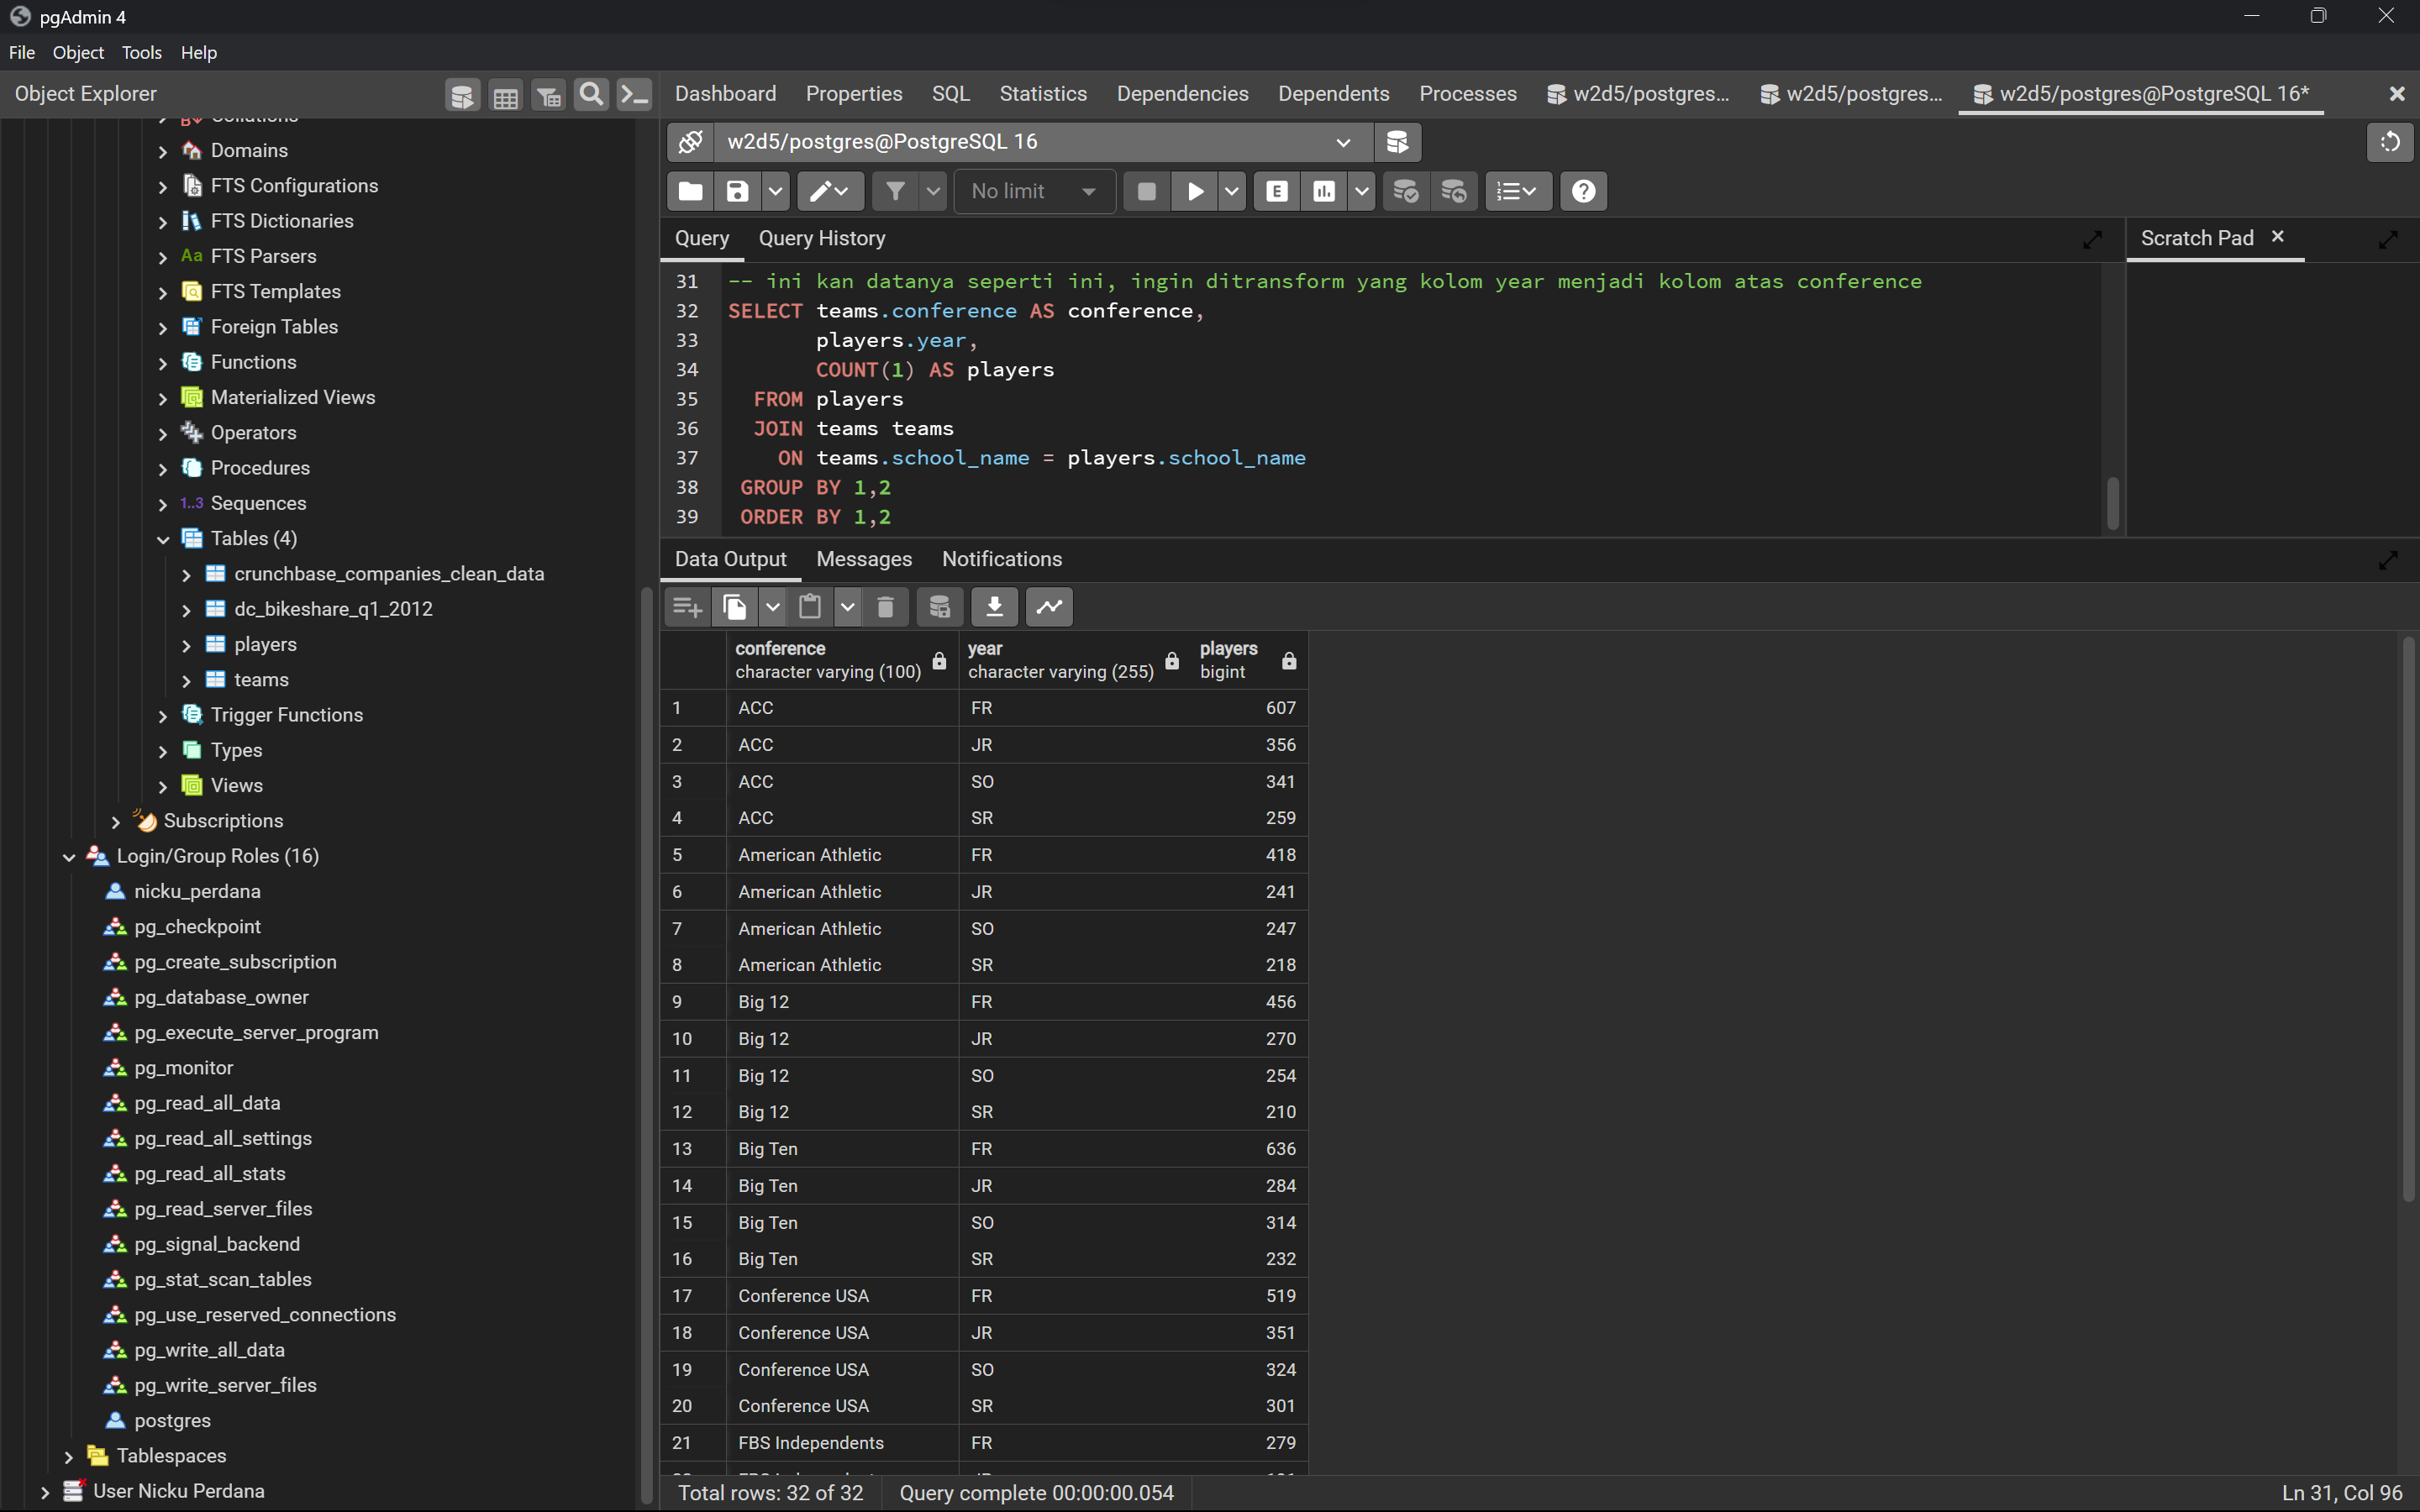

In order to transform the data, we'll need to put the above query into a subquery. It can be helpful to create the subquery and select all columns from it before starting to make transformations. Re-running the query at incremental steps like this makes it easier to debug if your query doesn't run. Note that you can eliminate the ORDER BY clause from the subquery since we'll reorder the results in the outer query.

```sql
SELECT *
  FROM (
        SELECT teams.conference AS conference,
               players.year,
               COUNT(1) AS players
            FROM players players
			JOIN teams
            ON teams.school_name = players.school_name
         GROUP BY 1,2
       ) sub
```


Assuming that works as planned (results should look exactly the same as the first query), it's time to break the results out into different columns for various years. Each item in the SELECT statement creates a column, so you'll have to create a separate column for each year:

```sql
SELECT conference,
       SUM(CASE WHEN year = 'FR' THEN players ELSE NULL END) AS fr,
       SUM(CASE WHEN year = 'SO' THEN players ELSE NULL END) AS so,
       SUM(CASE WHEN year = 'JR' THEN players ELSE NULL END) AS jr,
       SUM(CASE WHEN year = 'SR' THEN players ELSE NULL END) AS sr
  FROM (
        SELECT teams.conference AS conference,
               players.year,
               COUNT(1) AS players
          FROM players
          JOIN teams
            ON teams.school_name = players.school_name
         GROUP BY 1,2
       ) sub
 GROUP BY 1
 ORDER BY 1
 ```

But this could still be made a little better. You'll notice that the above query produces a list that is ordered alphabetically by Conference. It might make more sense to add a "total players" column and order by that (largest to smallest):

```sql
SELECT conference,
       SUM(players) AS total_players,
       SUM(CASE WHEN year = 'FR' THEN players ELSE NULL END) AS fr,
       SUM(CASE WHEN year = 'SO' THEN players ELSE NULL END) AS so,
       SUM(CASE WHEN year = 'JR' THEN players ELSE NULL END) AS jr,
       SUM(CASE WHEN year = 'SR' THEN players ELSE NULL END) AS sr
  FROM (
        SELECT teams.conference AS conference,
               players.year,
               COUNT(1) AS players
          FROM players
          JOIN teams
            ON teams.school_name = players.school_name
         GROUP BY 1,2
       ) sub
 GROUP BY 1
 ORDER BY 2 DESC
```



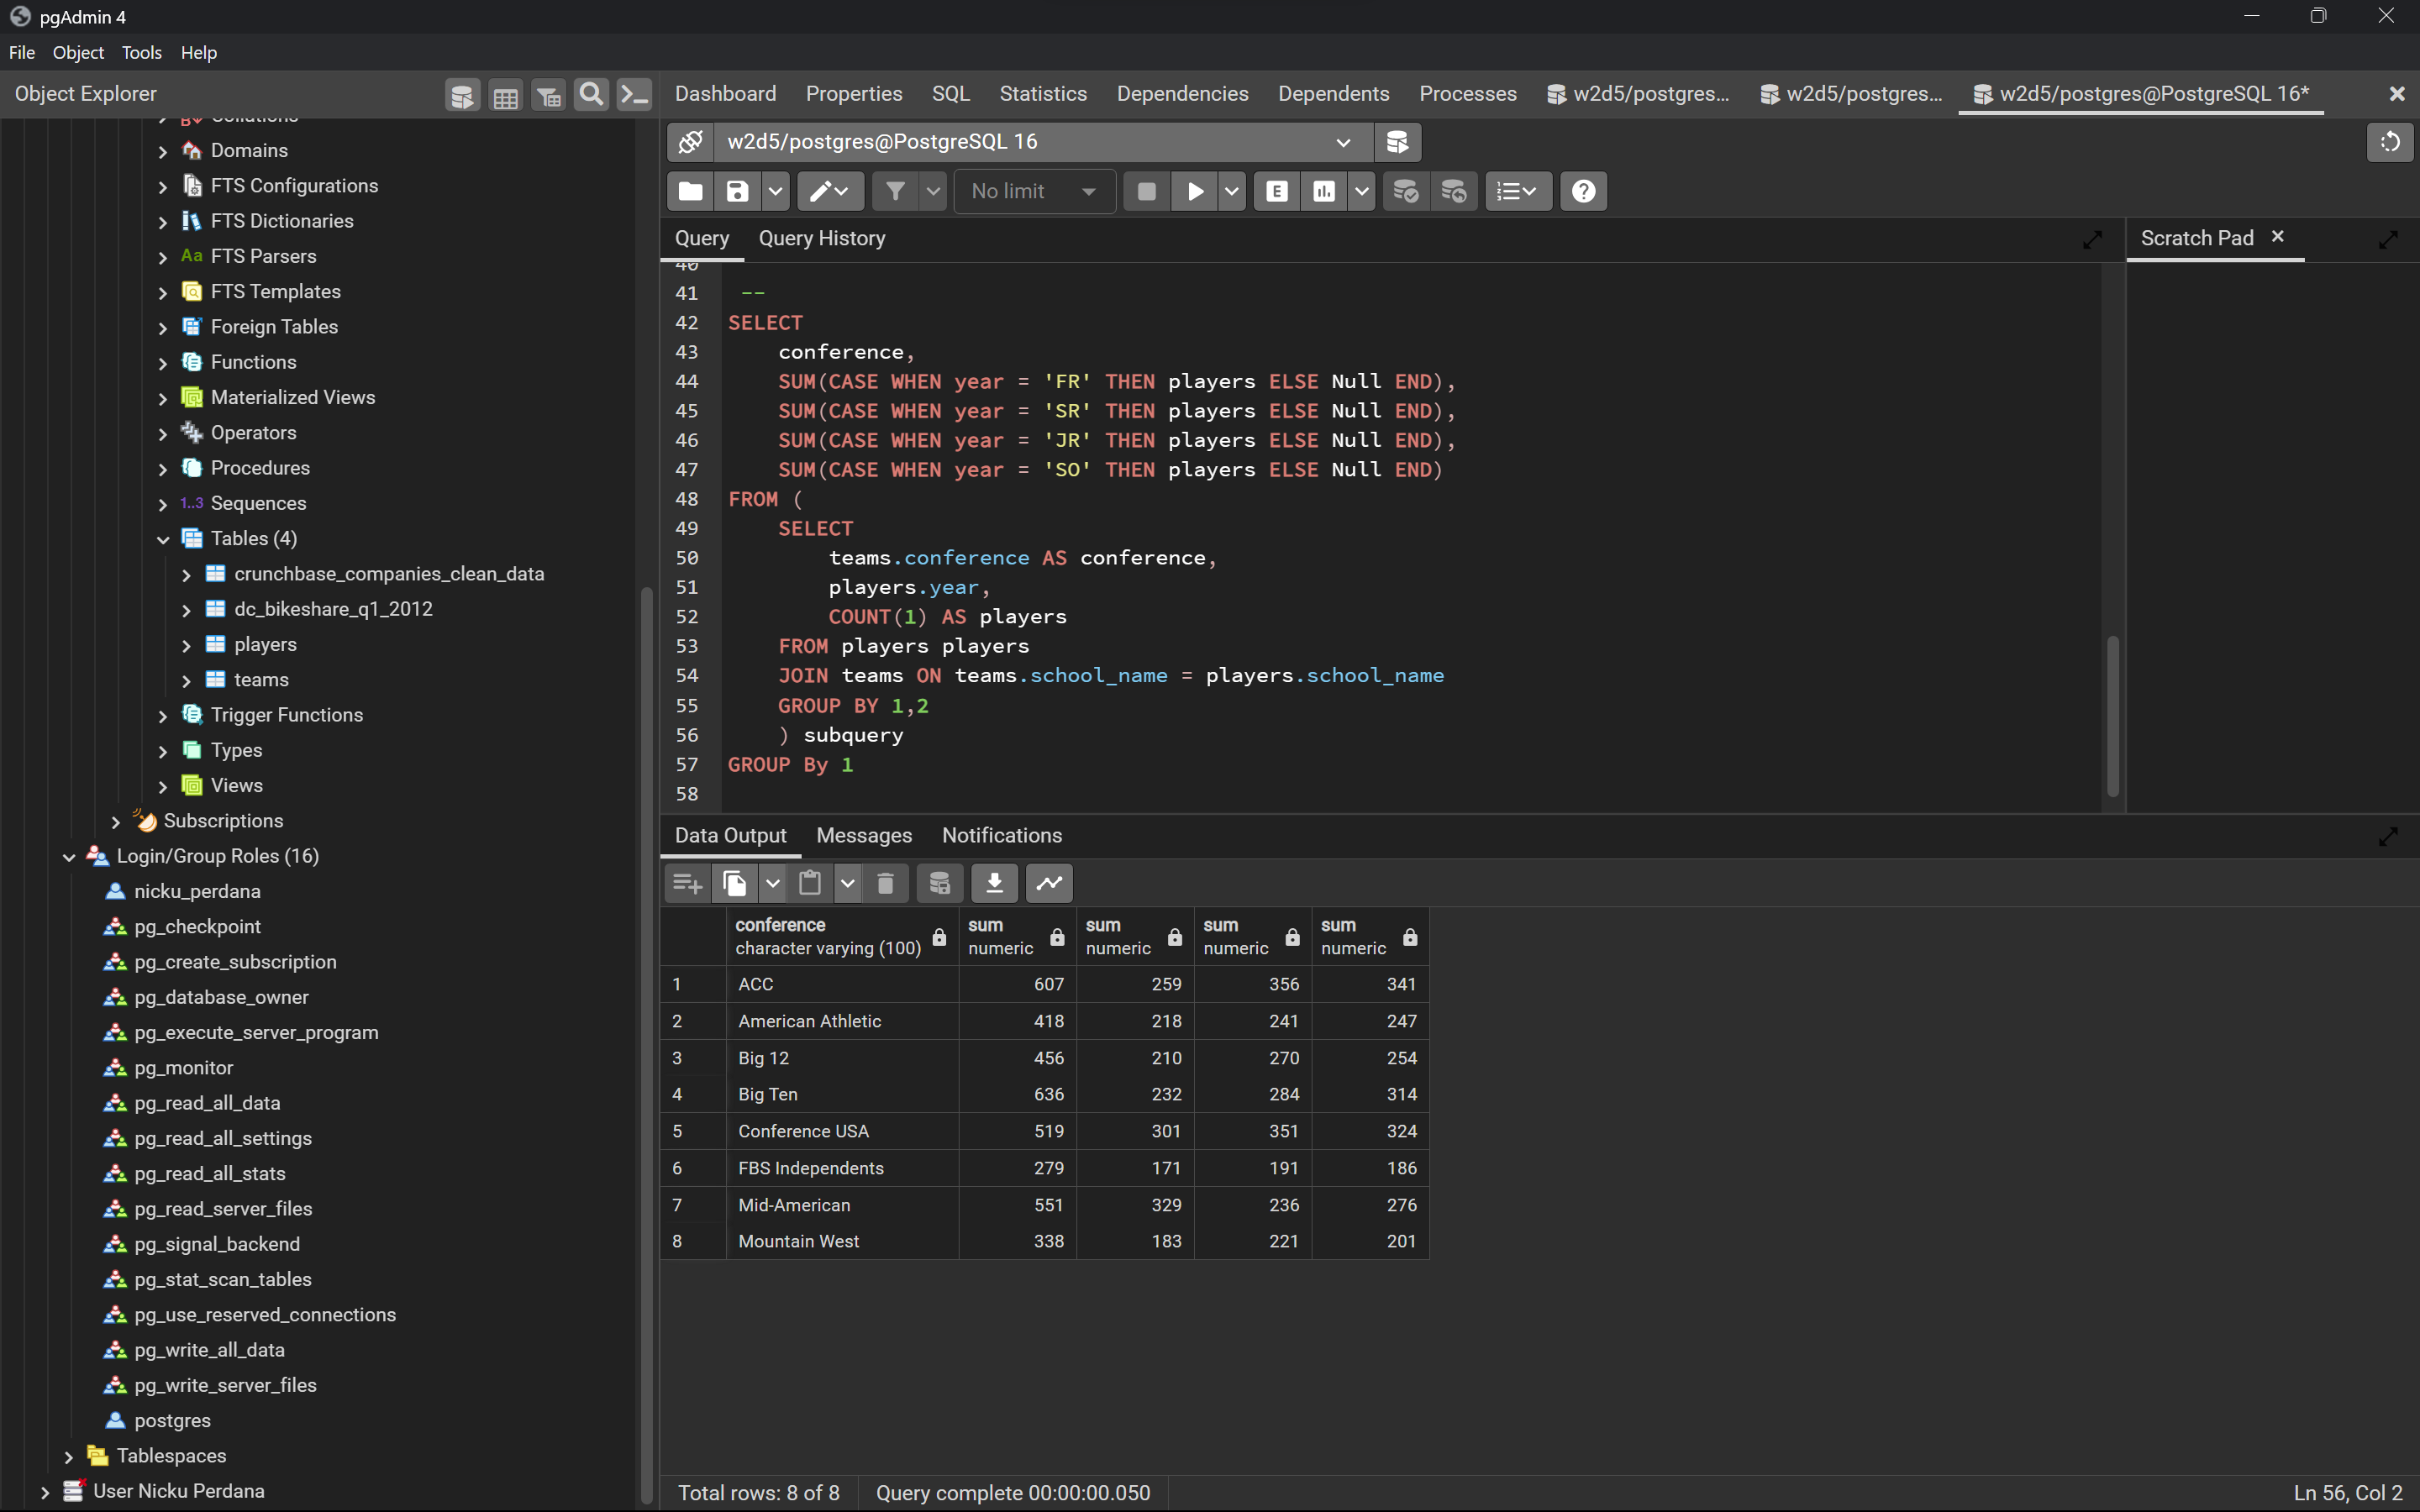

# SQL with Python

In [2]:
import psycopg2

## Connect to PostgreSQL Server (Localhost)

To connect with your Postgres server, you can run this syntax:

```python
# Replace these parameters with your actual database credentials
db_user = "postgres"
db_password = "1234" #Use your own password
db_host = "localhost"  # Usually "localhost" if running locally
db_port = "5432"  # Default is 5432

connection = psycopg2.connect(
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port
)
```

Because our case is in local, you cannot perform this section in Google Colab. Using Visual Studio Code or Jupyter Notebook is a must.

In [3]:
# Connect database dan 

# Replace these parameters with your actual database credentials
db_user = "postgres"
db_password = "1234" #Use your own password
db_host = "localhost"  # Usually "localhost" if running locally
db_port = "5432"  # Default is 5432

connection = psycopg2.connect(
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port
)

### Create Cursor Object

A cursor allows you to execute SQL queries on the connected database.

```py
cursor = connection.cursor()
```

## Case 1 - Create a Database

```py
connection.autocommit = True

q = sql.SQL('CREATE DATABASE pysql;')
cursor.execute(q)

cursor.close()
connection.close()
```

In this code snippet, we are executing a sequence of operations to create a new PostgreSQL database named "pysql."

1. `connection.autocommit = True`:
   This line sets the connection's `autocommit` property to `True`. By default, when you establish a connection to a PostgreSQL database using `psycopg2`, it operates in "transaction mode." This means that each database operation (like creating a table, inserting data, etc.) is treated as part of a single transaction. The changes are not committed (saved permanently) to the database until you explicitly call `commit()` on the connection or close the connection. Setting `autocommit = True` ensures that each individual SQL statement is automatically committed as soon as it is executed. This is particularly useful when you want to perform standalone operations that do not require transactional integrity.

2. `q = sql.SQL('CREATE DATABASE pysql;')`:
   In this line, we define an SQL statement using the `sql.SQL` class from the `psycopg2.sql` module. Using `sql.SQL` is recommended to avoid SQL injection vulnerabilities. Here, we are creating an SQL object that represents the SQL statement to create a new database called "pysql."

3. `cursor.execute(q)`:
   We execute the SQL statement `q` using the cursor's `execute()` method. The cursor is an object that allows us to interact with the database and execute SQL queries. In this case, we use the `execute()` method to create the database "pysql."

4. `cursor.close()` and `connection.close()`:
   After executing the SQL statement, we close the cursor and the connection to the database. Closing the cursor frees up resources associated with it, and closing the connection releases any connections and resources used to communicate with the PostgreSQL database.

## Case 2 - Create a Table

```py
connection = psycopg2.connect(
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port,
    database="pysql"
)

cursor = connection.cursor()

q = sql.SQL('''CREATE TABLE IF NOT EXISTS students (
    id SERIAL PRIMARY KEY,
    name VARCHAR(50),
    age INTEGER,
    campus_id INTEGER,
    total_grade FLOAT
);''')

cursor.execute(q)
connection.commit()
```

Since we already created a new database named "pysql", we should reconnect with the server along with the database.

after executing the SQL statement using `cursor.execute(q)`, the `connection.commit()` method is called. This additional step is necessary to commit the changes made to the database explicitly.

By default, when you perform database operations using `psycopg2`, the changes are not committed immediately. Instead, they are kept as part of an ongoing transaction until you explicitly call `commit()`.

## Case 3 - Insert Data into Table

```py
data_values = [
    ('Rafif Iman', 20, 1, 85.5),
    ('Hana Arisona', 21, 2, 90.2),
    ('Raka Purnomo', 19, 1, 78.9),
    ('Danu Irfansyah', 20, 3, 92.7),
    ('Rachman Ardhi', 22, 2, 88.1)
    ]

insert_query = "INSERT INTO students (name, age, campus_id, total_grade) VALUES (%s,%s,%s,%s)"

cursor.executemany(insert_query, data_values)

connection.commit()
```

The `cursor.executemany()` method in `psycopg2` is used to execute the same SQL statement multiple times with different sets of parameters. It is particularly useful when you want to perform bulk insert or update operations efficiently.

## Case 4 - Performing a SELECT Query

Since we only want to retrieve data from the server, in performing DQL you don't need `commit()`.

```py
select_query = "SELECT * FROM students;"
cursor.execute(select_query)

    # Fetch and print the results
rows = cursor.fetchall()
for row in rows:
    print(row)
```

To print all data you can use `cursor.fetchall()`. However, if you want to print the first row only, you can use `cursor.fetchone()`.

```py
select_query = "SELECT * FROM students;"
cursor.execute(select_query)

result = cursor.fetchone()

print(result)
```

## Connect to Pandas

Perhaps, using fetchall() or fetchone() to retrieve data is inconvinient, especially when we want to manipulate, preprocess, and cleaning the data.

Pandas provides function that can directly read the data from DQL:

```py
select_query = '''SELECT campus_id, MIN(age) AS min_age, MAX(age) AS max_age
                    FROM students
                    GROUP BY campus_id;'''
df = pd.read_sql_query(select_query, connection)

df
```